# Final Project - Braille Text Translator
## SCC0251 - Image Processing

### Students
* Caio Augusto Duarte Basso - NUSP 10801173
* Gabriel Garcia Lorencetti - NUSP 10691891
* Leonardo Rossi Luiz - NUSP 10851691
* Witor Matheus Alves de Oliveira - NUSP 10692190


### Main objective
The main objective of this project is to build a program able to recognize letters of a braille text present in an image digitally generated, i.e, given an input image, containing a text in braille, perform the translation to the alphabetic writing system.

### Iput images
The images used in this project were digitally generated, with the aid of a Braille letter dictionary and a code (which will be shown below) capable of generating Braille sentences, given an input.

### Importing required libraries

In [1]:
import numpy as np
import imageio
import scipy
import scipy.ndimage
import sys
import matplotlib.pyplot as plt
from skimage import morphology
from PIL import Image

### Generating a Braille Image
Given an input sentence, and with the help of the dictionary, the code generates an image containing the sentence in the Braille system.

In [2]:
# Gerando texto em braille para entrada do nosso problema
letters = [Image.open(x) for x in ['dictionary/a.png', 'dictionary/b.png', 'dictionary/c.png', 'dictionary/d.png',
                                   'dictionary/e.png', 'dictionary/f.png', 'dictionary/g.png', 'dictionary/h.png',
                                   'dictionary/i.png', 'dictionary/j.png', 'dictionary/k.png', 'dictionary/l.png',
                                   'dictionary/m.png', 'dictionary/n.png', 'dictionary/o.png', 'dictionary/p.png',
                                   'dictionary/q.png', 'dictionary/r.png', 'dictionary/s.png', 'dictionary/t.png',
                                   'dictionary/u.png', 'dictionary/v.png', 'dictionary/w.png', 'dictionary/x.png',
                                   'dictionary/y.png', 'dictionary/z.png', 'dictionary/_space.png'
                                  ]]

print("Type a word or sentence to create braille image.")
word = input().rstrip()

images = []
for letter in word:
    if letter != ' ':
        images.append(letters[ord(letter)-ord('a')])
    else: images.append(letters[26])
widths, heights = zip(*(i.size for i in images))

total_width = sum(widths)
max_height = max(heights)

new_im = Image.new('RGB', (total_width, max_height))

x_offset = 0
for im in images:
  new_im.paste(im, (x_offset,0))
  x_offset += im.size[0]

word_chunks = word.split(' ')
new_im.save(word_chunks[0]+'.png')

Type a word or sentence to create braille image.
hello


###  Preprocessing and quantisation
After performing the image generation, we will transform the image to grayscale using the Luminance method. Afterwards, as the image has only two colors, black and white, we will quantize the image to use only 1 bit, which will help us to make subsequent calculations more efficient. Finally, we apply the closing function.

#### Function declarations

In [3]:
def To_grayscale(img):    
    imgA = np.floor(img[:,:,0] * 0.299 + img[:,:,1] * 0.587 + img[:,:,2] * 0.114)
    imgA = imgA.astype('uint8')
    return imgA

In [4]:
def Quantisation (img, b):
    img = np.right_shift(img, 8-b)
    return img

In [26]:
def applying_filters(img, bits):
    img = To_grayscale(img)
    img = Quantisation(img, bits)
    img = morphology.closing(img, morphology.disk(4)).astype(np.uint8)
    return img

#### Reading and applying the functions on the image

In [27]:
img_name = input().rstrip() # read reference image's name

img_b = imageio.imread(img_name)

img = applying_filters(img_b, 1)

hello.png


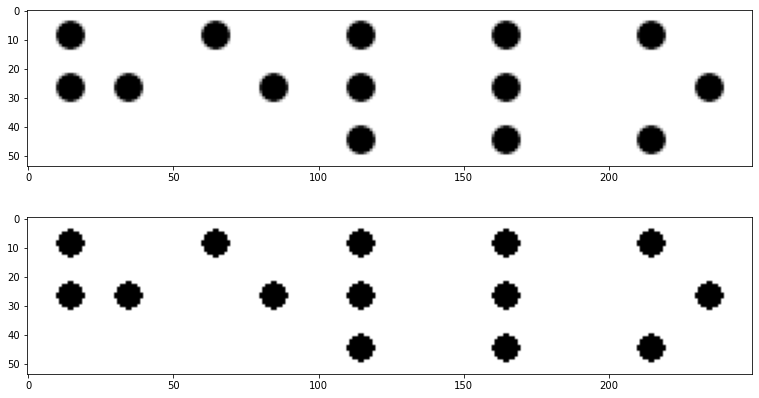

In [28]:
f, axarr = plt.subplots(2, 1)
f.set_size_inches(13, 7)
axarr[0].imshow(img_b, cmap="gray", vmin=0, vmax=255)
axarr[1].imshow(img, cmap="gray", vmin=0, vmax=1)
plt.show()

### Aplicando as funções nos pontos de referência

Para identificar cada letra, iremos utilizar duas imagens de referência: uma que representa os pontos da esquerda de cada letra em Braille, e uma que representa os pontos da direita. Para isso, iremos ler ambas e aplicar as mesmas funções que aplicamos na imagem que contém a frase.

In [29]:
####### reading image #######
dot_left_b = imageio.imread("dictionary/_left_dot.png")
dot_right_b = imageio.imread("dictionary/_right_dot.png")
#############################


###### Preprocessing and Quantisation ######
dot_left = applying_filters(dot_left_b, 1)
dot_right = applying_filters(dot_right_b, 1)

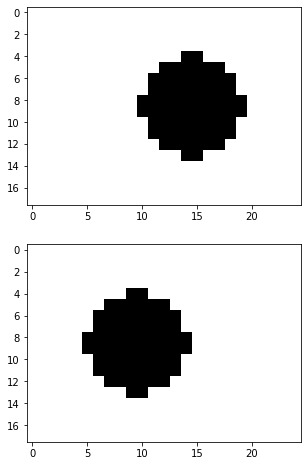

In [31]:
f, axarr = plt.subplots(2, 1)
f.set_size_inches(18, 8)
axarr[0].imshow(dot_left, cmap="gray", vmin=0, vmax=1)
axarr[1].imshow(dot_right, cmap="gray", vmin=0, vmax=1)
plt.show()

### Dividindo a imagem em blocos

In [9]:
def letter_representation(img, bits):
    
    N,M = img.shape
    windows = np.empty((int(M/50)*6, 18, 25))

    a = 0
    for i in range (0, M-1, 50): # creating windows
            temp_wind = img[:,i:i+50]
            n,m = temp_wind.shape
            windows[a] = temp_wind[:int(n/3),:int(m/2)] # 1
            windows[a+1] = temp_wind[:int(n/3),int(m/2):m] # 01
            windows[a+2] = temp_wind[int(n/3):int(2*n/3),:int(m/2)] # 00/1
            windows[a+3] = temp_wind[int(n/3):int(2*n/3),int(m/2):m] # 00/01
            windows[a+4] = temp_wind[int(2*n/3):n,:int(m/2)] # 00/00/1
            windows[a+5] = temp_wind[int(2*n/3):n,int(m/2):m] # 00/00/01
            a += 6
            
    return windows

### Euclidean distance calculation

In [10]:
def Difference(a, b):
    np.seterr(all='ignore')
    return np.sqrt(np.sum((a-b)**2))

### Encontrando a menor distância

In [11]:
def shortestDistance(windows, left, right, M):
    min_dist = sys.maxsize
    close = -1
    text = [[0]*6]
    
    # calculating the distances and finding the closest window
    a = 0
    for y in range (int(M/50)):
        letter_value = np.zeros((1,6), dtype=np.int8)
        for i in range(6):
            if Difference(left, windows[a+i]) <= 0.0001 or Difference(right, windows[a+i]) <= 0.0001:
                letter_value[0][i] = 1

                
        text = np.append(text, letter_value, axis=0)
        a += 6
    
    return text

In [12]:
M, N = c_ref_img.shape

windows = letter_representation(c_ref_img, bits)
text_value = shortestDistance(windows, grayscale_left, grayscale_right, N)
print("Valor do texto:")
print(text_value)

Valor do texto:
[[0 0 0 0 0 0]
 [1 0 1 1 0 0]
 [1 0 0 1 0 0]
 [1 0 1 0 1 0]
 [1 0 1 0 1 0]
 [1 0 0 1 1 0]]


### Gerando o dicionário

In [42]:
# Gerando dicionario de cada letra com seu respectivo valor vetorial
dic = {}
alphabet = ['dictionary/a.png', 'dictionary/b.png', 'dictionary/c.png', 'dictionary/d.png', 'dictionary/e.png', 
            'dictionary/f.png', 'dictionary/g.png', 'dictionary/h.png', 'dictionary/i.png', 'dictionary/j.png', 
            'dictionary/k.png', 'dictionary/l.png', 'dictionary/m.png', 'dictionary/n.png', 'dictionary/o.png', 
            'dictionary/p.png', 'dictionary/q.png', 'dictionary/r.png', 'dictionary/s.png', 'dictionary/t.png', 
            'dictionary/u.png', 'dictionary/v.png', 'dictionary/w.png', 'dictionary/x.png', 'dictionary/y.png', 
            'dictionary/z.png'
           ]

for temp in alphabet:
    temp_img = imageio.imread(temp)
    temp_img = applying_filters(temp_img, 1)
    temp_img = letter_representation(temp_img, 1)
    dic[temp[11]] = list(shortestDistance(temp_img,grayscale_left, grayscale_right, N)[1])
dic[' '] = [0,0,0,0,0,0]

In [43]:
# Comparando valor do texto com o dicionario e formando resultado final
final_text = ""
for i in range(text_value.shape[0]):
    for key, values in dic.items():
        if(list(text_value[i]) == list(values)):
            final_text += key
            
print("Texto traduzido:", final_text)

Texto traduzido:  hello
